## AMEX data int types - train
* その後めっちゃ引用されてるraddarのparquetを作ってるnotebookだと思う

In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
from config import train_data_pickle, test_data_pickle

In [3]:
x = pd.read_pickle(train_data_pickle)

In [4]:
xx = [-1, -0.5, 0, 0.5, 1]
tt = [t for t in xx if t>=0 and t<=0.01]
tt

[0]

In [5]:
def floorify(x, lo):
    """
    example: x in [0, 0.01] -> x += 0
    raddar_01の仮説に従い、一様乱数を潰す関数    
    """
    return lo if x <= lo+0.01 and x>= lo else x

def floorify_zeros(x):
    """
    look around values [0, 0.01] and determine if in proximity it's categorical. If yes - floorify
    0~0.01を探して、-0.01~0と0.01~0.02がなければ0にfloorify
    """
    has_zeros = len([t for t in x if t>=0 and t<=0.01]) > 0  # bool : 0~0.01(実質0)の要素が存在するか --

    # 接近してないか（-0.01~0, 0.01~0.02に要素ゼロ、ここに要素があるのに0に丸めたらマズイ） --
    no_proximity = len([t for t in x if t<0 and t>=-0.01]) == 0 and len([t for t in x if t>0.01 and t<=0.02]) == 0
    if not no_proximity:
        return x
    if not has_zeros:
        return x
    x = [floorify(t, 0.0) for t in x]    
    return x

def floorify_ones(x):
    """
    look around values [1, 1.01] and determine if in proximity it's categorical. If yes - floorify
    
    """
    has_ones = len([t for t in x if t>=1 and t<=1.01])>0 
    no_proximity = len([t for t in x if t<1 and t>=0.99])==0 and len([t for t in x if t>1.01 and t<=1.02])==0
    if not no_proximity:
        return x
    if not has_ones:
        return x
    x = [floorify(t, 1.0) for t in x]
    return x

def convert_na(x):
    """ nan -> -1 if positive values """
    if np.nanmin(x) >= 0:
        return [-1 if np.isnan(t) else t for t in x]

def convert_to_int(x):
    """ float -> int8 if possible """
    q = convert_na(x)
    if set(np.unique(q)).union({-1, 0, 1}) == {-1, 0, 1}:
        return [np.int8(t) for t in q]
    return x

def floorify_ones_and_zeros(t):
    """do everything"""
    t = floorify_zeros(t)
    t = floorify_ones(t)
    t = convert_to_int(t)
    return t

def floorify_frac(x, interval=1):
    """ 
    convert to int if float appears ordinal 
    ordinal: 序数、
    例えば適用しているB_30はvalue_countsが0.0, 1.0, 2.0の3パターン
    なので、interval=1で適用する
    """
    eps = 1e-6
    xt = (np.floor(x/interval+eps)).fillna(-1)
    if np.max(xt) <= 127:
        return xt.astype(np.int8)
    return xt.astype(np.int16)

## 関数の中で判定ではなくて、列ごとに関数を割り当てている
* つまり、各列の中身を見てどの処理当てるかは決め打ちしている

#### 例えば、B_30は明らかに0か1かしかなさそう

/home/marimo/poetry_projects/amex-default-prediction/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-0.0025, 0.0025)

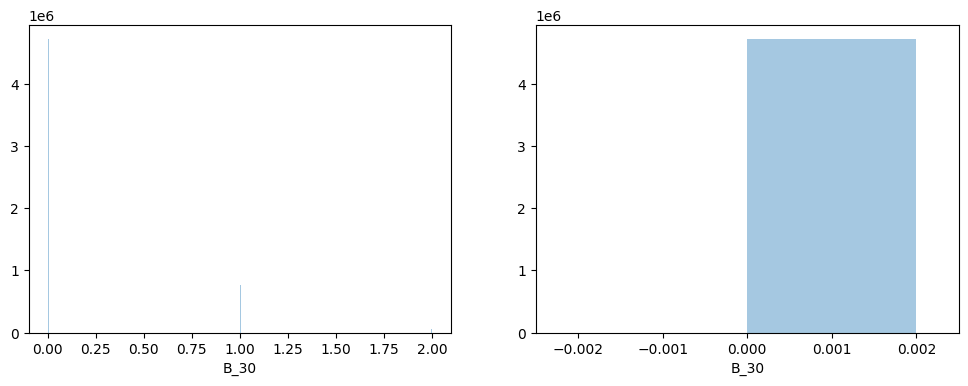

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(x["B_30"], bins=500, kde=False, ax=ax[0])
sns.distplot(x.loc[x.B_30 < 0.5, "B_30"], bins=500, kde=False, ax=ax[1])
ax[1].set_xlim([-0.0025, 0.0025])

#### B_4はinterval=1/78、小数で序数という観点がある
* このあたりはkde=Trueだと見えないし、引いて全体プロットしてても見えない

* B_4のintervalが78ってどうやって調べるんだ？
    * カタマリの最小値の差を見れば良い

<AxesSubplot:xlabel='B_4'>

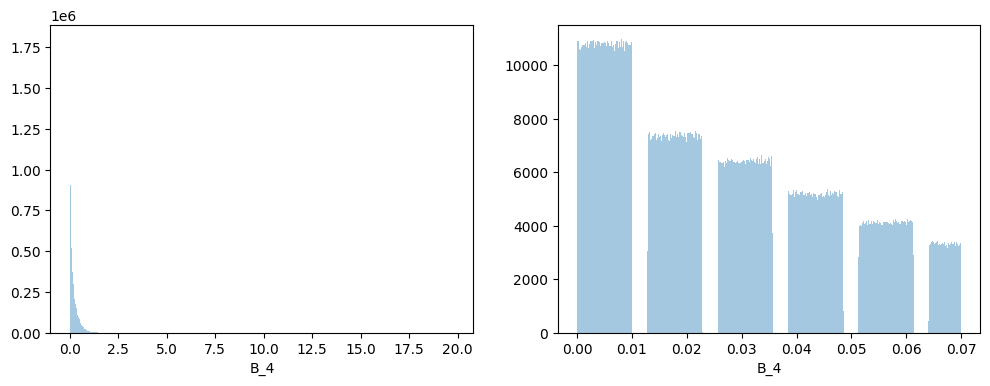

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(x["B_4"], bins=500, kde=False, ax=ax[0])
sns.distplot(x.loc[x.B_4< 0.07, "B_4"], bins=500, kde=False, ax=ax[1])

In [8]:
# カタマリの最小値の差を見る、第一群が0.00は確定、第二群の範囲を大体で取ってきてmin見れば良い
# ちょっと違うけどfloorの中に収まるなら行ける
print(1/78)
print(x.loc[(x.B_4 < 0.03) & (x.B_4 > 0.01), "B_4"].min())

0.01282051282051282
0.0128205359587859


/home/marimo/poetry_projects/amex-default-prediction/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marimo/poetry_projects/amex-default-prediction/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='B_4', ylabel='Density'>

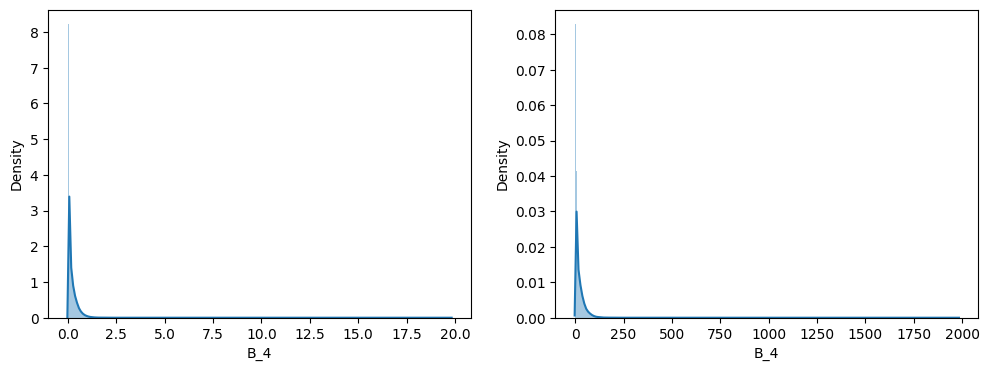

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.distplot(x["B_4"], bins=500, ax=ax[0])
sns.distplot(np.floor(x["B_4"]*100), bins=500, ax=ax[1])